In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip install pyworld

# **Dependencies**

In [4]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [0]:
import voicetreatment

In [7]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading the MNIST data set**

In [0]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

## The shape of the mnist dataset: 60000 batches with 28x28 pixel per digit
### Variation: Hand-writing style


In [166]:
input_train.shape[:]

(60000, 28, 28)

In [167]:
target_train.shape[:]

(60000,)

## Loading example data of a single digit into a Panda Dataframe 
### *(one can actually see the digit!)*

In [168]:
data_mnist = input_train[0]
df_mnist = pd.DataFrame(data_mnist)
df_mnist

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


# **Loading the sound file data set** *(example from a SF1)*

In [0]:
files = tf.gfile.Glob('/content/drive/My Drive/dataset/vcc2016/wav/Training Set/SF1/*.wav')


### Variation: Phonetic content (spectral envelope with 513 spectral lines)

In [0]:
features = []
FFT_SIZE = 1024
files = tf.gfile.Glob('/content/drive/My Drive/dataset/vcc2016/wav/Training Set/SF1/*.wav')
for elem in files:
  save = voicetreatment.analysis(elem, fft_size=FFT_SIZE, dtype=np.float32)
  for i in range(len(save)//100):
    features.append([save[i][0:513], 'SF1'])

## Adding in additional data for TM1
files2 = tf.gfile.Glob('/content/drive/My Drive/dataset/vcc2016/wav/Training Set/TM1/*.wav')
for elem in files2:
  save = voicetreatment.analysis(elem, fft_size=FFT_SIZE, dtype=np.float32)
  for i in range(len(save)//100):
    features.append([save[i][0:513], 'TM1'])

### The shape of a single data set from 1 speaker (SF1 specifically): 1048 batches with 1x513 dimensional spectral line

In [10]:
print("From 162 utterances in SF1 & TM1 respectively, we have:",len(features),"batches")
print("In each batch, we have:",len(features[0][0]),"spectral lines")

# Note that different speakers have different number of batches
count=0
for i in range(len(features)):
  if features[i][1] == 'SF1':
    count += 1
print('Note that different speakers have different number of batches (Due to varying length of sound files):')
print("From 162 utterances in SF1, we have:",count,"batches")
print("From 162 utterances in TM1, we have:",len(features)-count,"batches")


From 162 utterances in SF1 & TM1 respectively, we have: 2049 batches
In each batch, we have: 513 spectral lines
Note that different speakers have different number of batches (Due to varying length of sound files):
From 162 utterances in SF1, we have: 1048 batches
From 162 utterances in TM1, we have: 1001 batches


### Loading example data of a single batch into a Panda Dataframe

In [11]:
data_voice_example = features[0][0]
df_voice_example = pd.DataFrame(data_voice_example.reshape(1,513))
df_voice_example 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512
0,-1.457472,-1.457342,-1.456953,-1.456305,-1.455399,-1.454236,-1.452813,-1.451097,-1.448996,-1.446443,-1.443495,-1.440371,-1.437428,-1.435135,-1.434049,-1.434803,-1.438098,-1.444692,-1.455393,-1.471047,-1.492509,-1.520596,-1.555973,-1.598961,-1.649231,-1.705566,-1.766107,-1.829283,-1.894446,-1.961392,-2.029951,-2.09996,-2.171255,-2.243674,-2.317053,-2.391225,-2.466025,-2.541285,-2.616843,-2.692535,...,-4.718684,-4.687128,-4.657517,-4.629808,-4.603922,-4.579759,-4.557208,-4.536152,-4.516479,-4.498081,-4.480857,-4.464716,-4.449578,-4.43537,-4.422033,-4.409515,-4.397777,-4.386784,-4.376511,-4.366939,-4.358051,-4.349832,-4.342267,-4.335333,-4.329004,-4.323243,-4.318007,-4.313247,-4.30892,-4.304986,-4.301418,-4.2982,-4.295326,-4.292801,-4.290633,-4.288836,-4.287421,-4.2864,-4.285785,-4.285579


## Visualization (Spectral Envelope) of a single batch

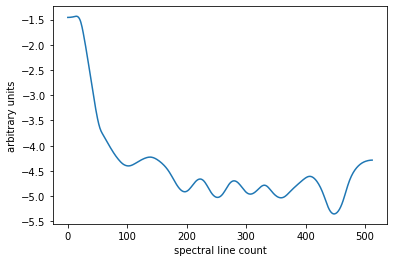

In [12]:
plt.plot(data_voice_example)
plt.ylabel('arbitrary units')
plt.xlabel('spectral line count')
plt.show()

## General Overview of entire voice dataset (SF1 and TM1 exclusively)

In [13]:
featuresDF = pd.DataFrame(features, columns=['feature','class_label'])
featuresDF

,feature,class_label
0,"[-1.4574722, -1.4573424, -1.4569532, -1.456305...",SF1
1,"[-1.5504639, -1.5503545, -1.5500277, -1.549486...",SF1
2,"[-1.4721012, -1.472067, -1.4719646, -1.4717935...",SF1
3,"[-1.4450252, -1.4448296, -1.4442463, -1.443289...",SF1
4,"[-1.4598114, -1.4595034, -1.458595, -1.4571028...",SF1
...,...,...
2044,"[-1.4646225, -1.4643795, -1.4636531, -1.462436...",TM1
2045,"[-1.4451274, -1.4449229, -1.4443564, -1.443427...",TM1
2046,"[-1.4536667, -1.4536334, -1.4535317, -1.453354...",TM1
2047,"[-1.4366106, -1.4365959, -1.4365529, -1.436485...",TM1


In [0]:
y = np.array(featuresDF.class_label.tolist())
X = np.array(featuresDF.feature.tolist())
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 127)

x_train = x_train.reshape(len(x_train),1,513)
x_test = x_test.reshape(len(x_test),1,513)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [15]:
x_train.shape[:]

(1639, 1, 513)

In [16]:
y_train.shape[:]

(1639,)

# **Data & model configuration**

## Voice


In [0]:
img_width_voice, img_height_voice = x_train.shape[1], x_train.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim_voice = 128
num_channels = 1

## MNIST


In [0]:
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

# **Data preprocessing**


## Voice

In [0]:
# Reshape data
input_train_voice = x_train.reshape(x_train.shape[0], img_height_voice, img_width_voice, num_channels)
input_test_voice = x_test.reshape(x_test.shape[0], img_height_voice, img_width_voice, num_channels)
input_shape_voice = (img_height_voice, img_width_voice, num_channels)

# Parse numbers as floats
input_train_voice = input_train_voice.astype('float32')
input_test_voice = input_test_voice.astype('float32')

# Normalize data
input_train_voice = input_train_voice / 8
input_test_voice = input_test_voice / 8

In [181]:
input_train_voice.shape[:]

(1639, 513, 1, 1)

## MNIST

In [0]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [183]:
input_train.shape[:]

(60000, 28, 28, 1)

# **Import keras functional APIs**

In [0]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# **Creating the Encoder**

## MNIST

In [0]:
# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)
conv_shape = K.int_shape(cx)

## Voice

In [0]:
# Definition
i_voice       = Input(shape=input_shape_voice, name='encoder_input_voice')
cx_voice      = Conv2D(filters=8, kernel_size=[7,1], strides=[3,1], padding='same', activation='relu')(i_voice)
cx_voice      = BatchNormalization()(cx_voice)
cx_voice     = Conv2D(filters=16, kernel_size=[7,1], strides=[3,1], padding='same', activation='relu')(cx_voice)
cx_voice      = BatchNormalization()(cx_voice)
x_voice      = Flatten()(cx_voice)
x_voice       = Dense(512, activation='relu')(x_voice)
x_voice       = BatchNormalization()(x_voice)
mu_voice      = Dense(latent_dim_voice, name='latent_mu_voice')(x_voice)
sigma_voice   = Dense(latent_dim_voice, name='latent_sigma_voice')(x_voice)
conv_shape_voice = K.int_shape(cx_voice)

# **Reparametrization Trick**

## MNIST

In [0]:
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])


## Voice

In [0]:
def sample_z_voice(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

z_voice = Lambda(sample_z_voice, output_shape=(latent_dim_voice, ), name='z')([mu_voice, sigma_voice])


# **Activate Encoder**

## MNIST

In [215]:
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 14, 14, 8)    32          conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 7, 7, 16)     1168        batch_normalization_28[0][0]     
____________________________________________________________________________________________

## Voice


In [39]:
encoder_voice = Model(i_voice, [mu_voice, sigma_voice, z_voice], name='encoder_voice')
encoder_voice.summary()

Model: "encoder_voice"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_voice (InputLayer (None, 513, 1, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 171, 1, 8)    64          encoder_input_voice[0][0]        
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 171, 1, 8)    32          conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 57, 1, 16)    912         batch_normalization_10[0][0]     
______________________________________________________________________________________

# **Creating the decoder**

## MNIST

In [0]:
# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

## Voice

In [0]:
# Definition
d_i_voice   = Input(shape=(latent_dim_voice, ), name='decoder_input_voice')
x_voice     = Dense(conv_shape_voice[1] * conv_shape_voice[2] * conv_shape_voice[3], activation='relu')(d_i_voice)
x_voice     = BatchNormalization()(x_voice)
x_voice    = Reshape((conv_shape_voice[1], conv_shape_voice[2], conv_shape_voice[3]))(x_voice)
cx_voice    = Conv2DTranspose(filters=16, kernel_size=[7,1], strides=[3,1], padding='same', activation='relu')(x_voice)
cx_voice    = BatchNormalization()(cx_voice)
cx_voice    = Conv2DTranspose(filters=8, kernel_size=[7,1], strides=[3,1], padding='same',  activation='relu')(cx_voice)
cx_voice    = BatchNormalization()(cx_voice)
o_voice     = Conv2DTranspose(filters=num_channels, kernel_size=[7,1], activation='sigmoid', padding='same', name='decoder_output_voice')(cx_voice)

# **Activate the decoder**

## MNIST

In [198]:
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 784)               2352      
_________________________________________________________________
batch_normalization_37 (Batc (None, 784)               3136      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_38 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 8)         1160

## Voice

In [41]:
decoder_voice = Model(d_i_voice, o_voice, name='decoder_voice')
decoder_voice.summary()

Model: "decoder_voice"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input_voice (InputLa (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 912)               117648    
_________________________________________________________________
batch_normalization_13 (Batc (None, 912)               3648      
_________________________________________________________________
reshape_2 (Reshape)          (None, 57, 1, 16)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 171, 1, 16)        1808      
_________________________________________________________________
batch_normalization_14 (Batc (None, 171, 1, 16)        64        
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 513, 1, 8)       

# **VAE whole model**

## MNIST

In [228]:
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 17208     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9137      
Total params: 26,345
Trainable params: 24,641
Non-trainable params: 1,704
_________________________________________________________________


## Voice

In [42]:
vae_outputs_voice = decoder_voice(encoder_voice(i_voice)[2])
vae_voice         = Model(i_voice, vae_outputs_voice, name='vae_voice')
vae_voice.summary()

Model: "vae_voice"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input_voice (InputLa (None, 513, 1, 1)         0         
_________________________________________________________________
encoder_voice (Model)        [(None, 128), (None, 128) 601904    
_________________________________________________________________
decoder_voice (Model)        (None, 513, 1, 1)         124161    
Total params: 726,065
Trainable params: 723,121
Non-trainable params: 2,944
_________________________________________________________________


# **Loss function**

## MNIST

In [0]:
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

## Voice

In [0]:
def kl_reconstruction_loss_voice(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width_voice * img_height_voice
  # KL divergence loss
  kl_loss = 1 + sigma_voice - K.square(mu_voice) - K.exp(sigma_voice)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

# **Compilation & Training**

# MNIST

In [237]:
# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 51s 1ms/step - loss: 170.5742 - val_loss: 165.8131
Epoch 2/50
48000/48000 [==============================] - 46s 968us/step - loss: 164.8064 - val_loss: 161.9199
Epoch 3/50
48000/48000 [==============================] - 46s 961us/step - loss: 162.3142 - val_loss: 161.1938
Epoch 4/50
48000/48000 [==============================] - 46s 961us/step - loss: 160.9443 - val_loss: 159.1278
Epoch 5/50
48000/48000 [==============================] - 46s 953us/step - loss: 159.8106 - val_loss: 157.5763
Epoch 6/50
48000/48000 [==============================] - 46s 957us/step - loss: 159.0459 - val_loss: 156.3574
Epoch 7/50
48000/48000 [==============================] - 46s 957us/step - loss: 158.2659 - val_loss: 157.4409
Epoch 8/50
48000/48000 [==============================] - 46s 957us/step - loss: 157.9687 - val_loss: 155.9728
Epoch 9/50
48000/48000 [==============================] - 46s 96

# Voice

In [44]:
# Compile VAE
vae_voice.compile(optimizer='adam', loss=kl_reconstruction_loss_voice)

# Train autoencoder
hist = vae_voice.fit(input_train_voice, input_train_voice, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 1311 samples, validate on 328 samples
Epoch 1/50
1311/1311 [==============================] - 3s 2ms/step - loss: 537.1406 - val_loss: 350.1438
Epoch 2/50
1311/1311 [==============================] - 1s 1ms/step - loss: 398.1060 - val_loss: 310.4491
Epoch 3/50
1311/1311 [==============================] - 1s 1ms/step - loss: 339.2663 - val_loss: 273.1285
Epoch 4/50
1311/1311 [==============================] - 1s 1ms/step - loss: 291.2174 - val_loss: 225.0197
Epoch 5/50
1311/1311 [==============================] - 1s 1ms/step - loss: 238.0045 - val_loss: 161.3988
Epoch 6/50
1311/1311 [==============================] - 2s 1ms/step - loss: 173.0406 - val_loss: 82.0316
Epoch 7/50
1311/1311 [==============================] - 1s 1ms/step - loss: 95.9541 - val_loss: -1.9239
Epoch 8/50
1311/1311 [==============================] - 1s 1ms/step - loss: 5.9284 - val_loss: -88.7037
Epoch 9/50
1311/1311 [==============================] - 1s 1ms/step - loss: -97.2463 - val_loss: -176.6178
Epo

### Loss visualization

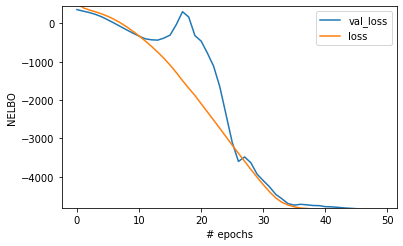

In [46]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))
#NELBO
fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())


plt.show()

# **Visualizing VAE results**

# MNIST
The MNIST dataset only has 2 dimensional latent representation. Each of these clusters (differentiated by the color map) represents a digit. Close clusters are digits that are structurally similar (digits that share information in the latent space).

### MNIST 2-dimensional latent space visualization

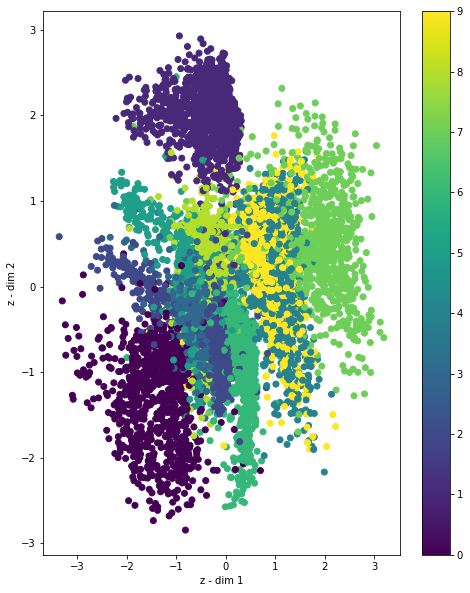

In [239]:
def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

data = (input_test, target_test)
viz_latent_space(encoder, data)

# Voice
On the other hand, the voice dataset has a 128 dimensional latent space. Each of these clusters represent a speaker from the original vcc dataset (Purple: SF1, Yellow: TM1).

### Voice 2-dimensional latent space visualization

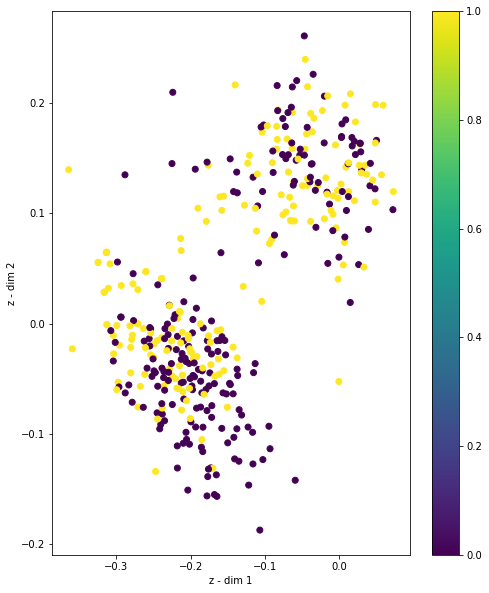

In [29]:
def viz_latent_space_voice(encoder_voice, data):
  input_data, target_data = data
  mu, _, _ = encoder_voice.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

data_v = (input_test_voice, y_test)
viz_latent_space_voice(encoder_voice, data_v)

In [0]:
store = []
for i in range(len(encoder_voice.predict(input_test_voice)[0])):
  store.append(encoder_voice.predict(input_test_voice)[0][i])


### Voice n-dimensional latent space visualization (n>2)
We now visualize the *mu* in a 128-dimensional latent space. Each column represents a dimension. We will analyze the first 10 dimensions of the 128-dimensional latent space.

In [31]:
storeFrame = pd.DataFrame(store)
#storeFrame = storeFrame.transpose()
storeFrame

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.027500,0.162590,0.182411,-0.000493,0.066336,0.246371,0.022451,-0.074251,-0.014256,-0.040323,0.075130,-0.135227,0.056195,0.134524,0.192137,-0.066058,-0.229113,0.040373,0.325309,0.142087,-0.252006,-0.196568,-0.293806,0.067029,-0.284660,0.220398,0.041405,0.133958,-0.075743,0.140107,0.305017,0.002237,0.037927,0.331159,0.279531,0.019116,0.207909,0.141357,-0.230880,-0.051764,...,-0.075508,0.397225,-0.317664,0.420916,0.114175,0.111886,0.242337,0.273244,-0.013108,-0.114355,-0.080816,-0.042072,-0.004639,0.162598,-0.032122,-0.080671,0.159660,0.005180,-0.159878,0.108709,-0.074342,0.386937,-0.097641,0.211670,-0.081776,-0.017081,0.043241,-0.056034,-0.100374,-0.063216,-0.162204,0.085497,0.071907,-0.170276,-0.033810,-0.097782,0.005929,0.036408,-0.124096,0.075665
1,-0.094641,-0.092916,-0.126188,0.156269,-0.020999,0.117872,-0.131375,0.083229,-0.070856,-0.370235,-0.024497,0.080738,0.162804,-0.390902,0.097248,0.198988,-0.188338,-0.056269,-0.058014,-0.117421,0.152235,0.141386,0.008972,-0.247086,-0.104447,0.155523,-0.117102,-0.032297,-0.004665,-0.154535,-0.046179,0.023625,-0.007153,-0.033517,0.027898,-0.101520,0.107666,0.000850,0.170985,-0.148962,...,0.162098,-0.207593,0.250731,0.063108,-0.169606,0.020920,-0.123846,-0.013720,0.089775,0.160323,0.225999,0.132182,0.186923,0.199448,0.155135,-0.250138,0.027151,0.079133,-0.162388,0.142682,0.057690,0.080655,-0.083791,-0.135319,0.205964,-0.153499,0.022133,-0.092893,0.105049,0.025391,-0.024033,-0.035384,-0.175193,-0.198684,0.218089,-0.110154,0.146617,0.041332,0.153053,0.266080
2,-0.303321,-0.027262,-0.063625,0.012594,0.029913,0.158563,-0.133097,0.011427,-0.015714,-0.360891,0.012842,0.138424,0.111896,-0.130801,0.164797,0.011878,-0.206136,-0.059309,0.017863,0.050722,-0.030974,0.132841,0.024571,-0.157371,-0.141703,-0.045127,-0.021003,-0.088941,0.063385,-0.109712,-0.111097,0.051287,-0.091644,0.169434,0.059209,-0.081836,0.034146,-0.035639,0.005738,-0.257088,...,-0.023269,0.050583,0.065047,0.119024,-0.007015,-0.037822,-0.125056,0.089269,0.047013,0.069764,0.007655,-0.070976,0.201343,0.131216,0.050894,-0.178880,0.004658,0.118889,-0.177031,0.063330,0.043654,0.179586,0.017383,0.064878,0.170844,-0.110472,0.026841,-0.140595,-0.004809,0.053222,-0.086854,-0.102805,-0.105200,-0.022985,0.203941,-0.050982,0.097233,-0.076731,0.041634,0.177549
3,-0.172626,-0.130606,-0.113333,0.065899,-0.053560,0.114964,-0.194293,0.073987,-0.069242,-0.342591,-0.082332,-0.032990,0.122583,-0.346927,0.171276,0.187675,-0.158260,-0.031660,-0.051375,-0.056896,0.112838,0.150878,0.054122,-0.301961,-0.126236,0.077747,-0.085577,0.026445,0.025596,-0.158227,-0.069652,-0.007325,-0.033024,-0.098598,-0.019937,-0.112415,0.074189,-0.069069,0.117744,-0.158110,...,0.066038,-0.187126,0.171888,0.109947,-0.190773,-0.030204,-0.169369,-0.071105,0.156032,0.118950,0.218745,0.178672,0.177684,0.241689,0.182384,-0.242690,0.038504,0.079803,-0.122969,0.119075,-0.005916,0.093749,-0.016864,-0.097922,0.198455,-0.111703,-0.022815,-0.122763,0.043069,0.042902,-0.096917,-0.034627,-0.192457,-0.257362,0.297645,-0.137610,0.194954,-0.024868,0.158490,0.250060
4,-0.103645,0.173618,0.090076,0.059055,-0.031391,0.252784,-0.007241,-0.073049,0.087668,-0.011378,0.023691,-0.036157,-0.043779,0.089964,0.073054,-0.120489,-0.110000,0.071113,0.297234,0.086022,-0.254461,-0.007352,-0.128792,0.047465,-0.215539,0.124114,-0.028051,0.098916,0.027991,0.074504,-0.017534,0.095440,-0.144855,0.292200,0.175001,-0.135416,0.145419,0.116435,-0.181708,-0.174315,...,0.033893,0.210782,-0.113648,0.448893,0.023877,0.231576,0.239461,0.121399,0.043635,0.054960,-0.085071,-0.065604,0.058664,0.154999,0.006383,-0.254660,0.157288,-0.121719,-0.061955,-0.042073,-0.024589,0.342438,-0.066691,0.086383,-0.081708,0.032453,0.021139,-0.097308,-0.151463,0.024715,-0.151528

In [0]:
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


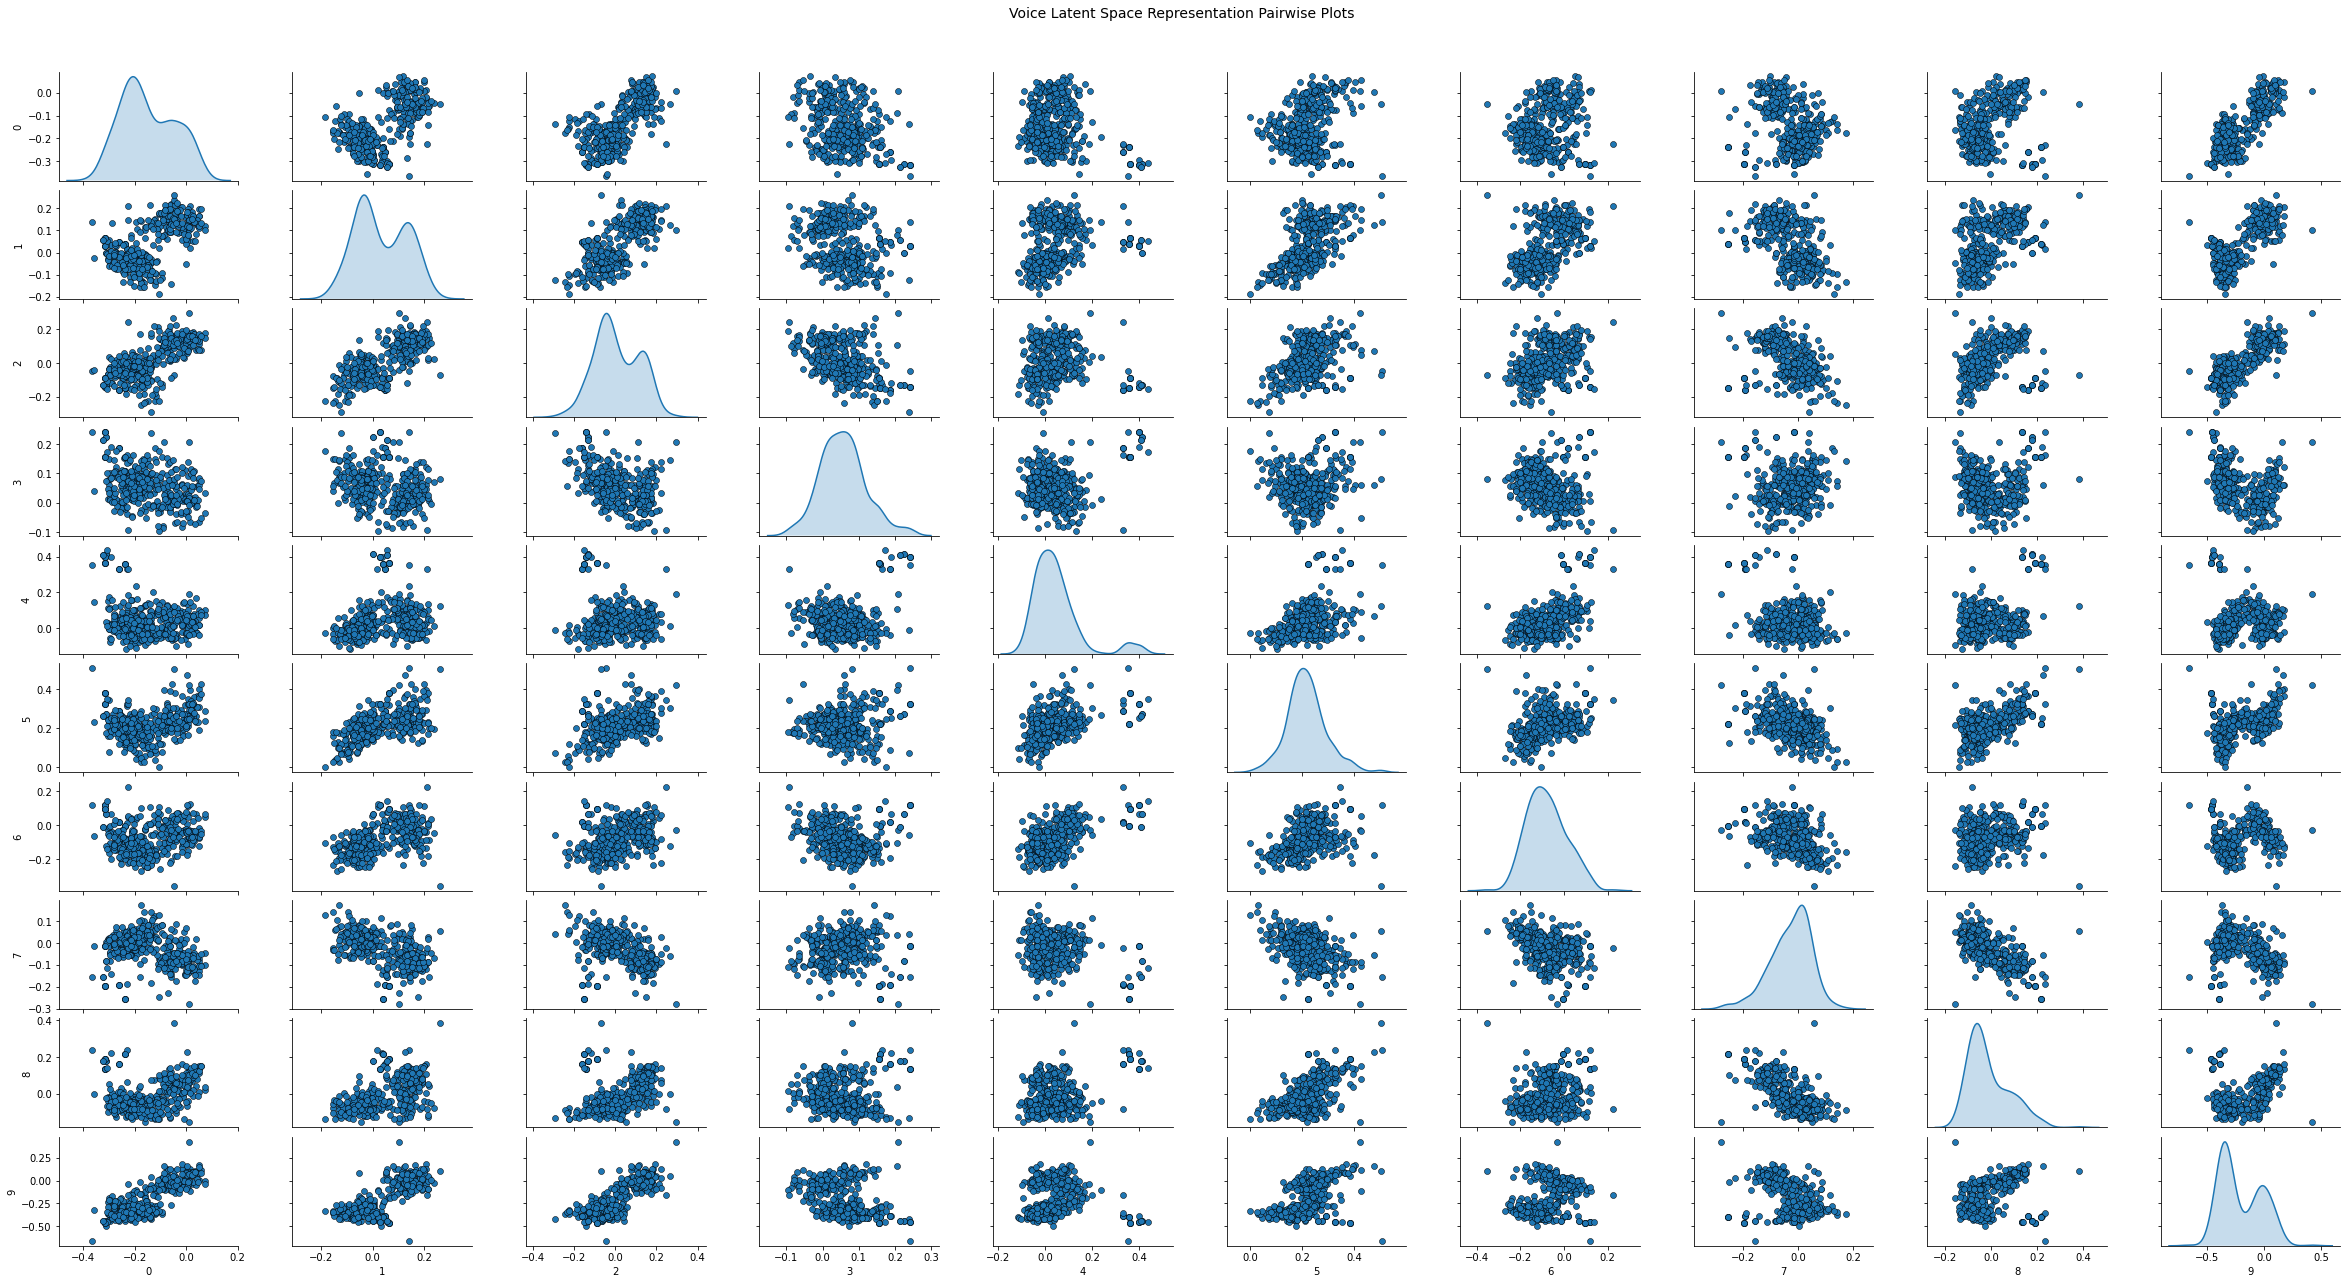

In [34]:
pp = sns.pairplot(storeFrame.loc[:, 0:9], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Voice Latent Space Representation Pairwise Plots', fontsize=14)